# **Import Libraries and mount drive**

In [ ]:
from scipy import io
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from PIL import Image
from math import log10
!pip install python-docx
import docx
import csv
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import SpectralClustering

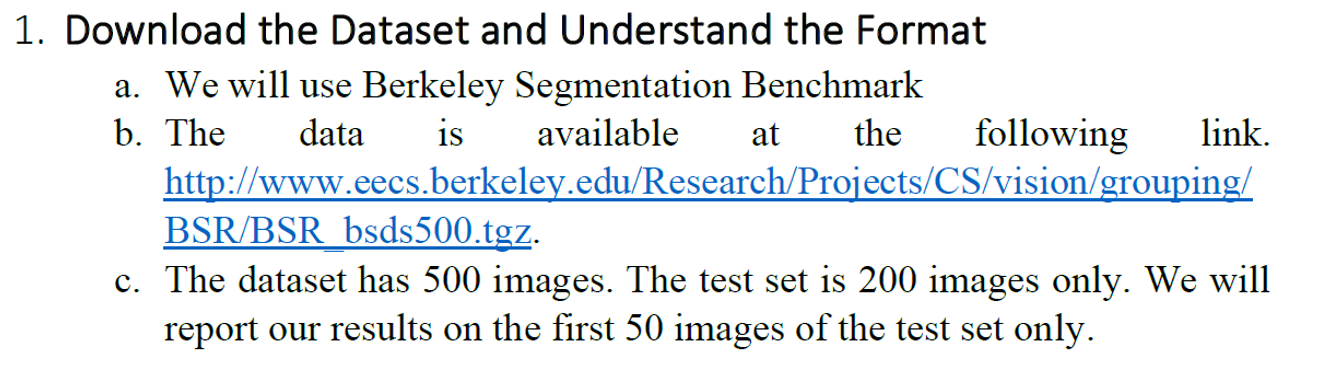

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Get true labels from groundtruth**

In [ ]:
def get_seg(name,category):
  # open image
  path ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/"
  im = Image.open(path+category+"/"+name+".jpg") 
  pix_no=np.array(im).shape[0]*np.array(im).shape[1]
  file = io.loadmat(path+"groundTruth/"+category+"/"+name+".mat") 
  # create array to hold labels of each ground truth
  segmentations= np.empty((0,pix_no))
  for i in range(file['groundTruth'][0].size):
    segmap = file['groundTruth'][0][i][0][0][0]
    segmentations=np.vstack((segmentations,segmap.reshape((pix_no,))))
  return segmentations

# **Visualization**
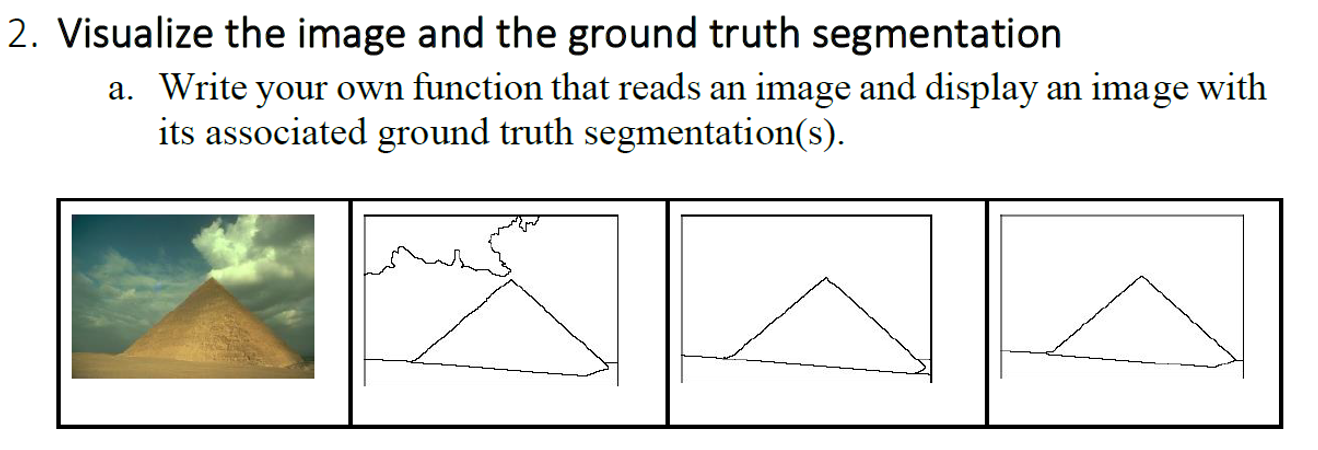

In [ ]:
def read_image_truth(name,category,doc=None):
  path ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/"
  # show original image
  print("Original Image")
  img_path = f"/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/tunning_bonus/{name}/"
  im = Image.open(path+category+"/"+name+".jpg") 
  pyplot.imshow(np.array(im))
  if doc is not None:  
    doc.add_paragraph("Original image :"+name)
    pyplot.savefig(img_path+"original.png")
    doc.add_picture(img_path+"original.png")
    pyplot.show()
  # show ground truth
  print("Ground truth images ")
  file = io.loadmat(path+"groundTruth/"+category+"/"+name+".mat")
  #print("M = ",file['groundTruth'][0].size)  
  
  for i in range(file['groundTruth'][0].size):
    print("M:",i+1)
    edges = file['groundTruth'][0][i][0][0][1]*255
    segmap = file['groundTruth'][0][i][0][0][0]
    fig, (ax1, ax2) = pyplot.subplots(1, 2)
    ax1.imshow(edges)
    ax2.imshow(segmap)
    if doc is not None:  
      doc.add_paragraph("Ground :"+str(i))
      pyplot.savefig(img_path+f"M_{str(i)}.png")
      doc.add_picture(img_path+f"M_{str(i)}.png")
    pyplot.show()

Original Image
Ground truth images 
M =  6
M: 1


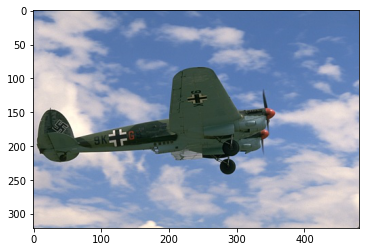

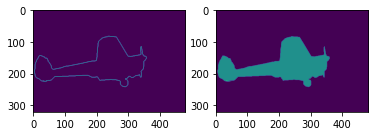

M: 2


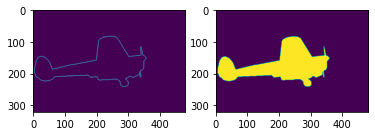

M: 3


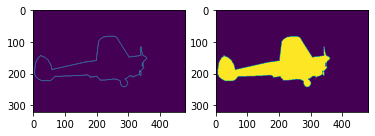

M: 4


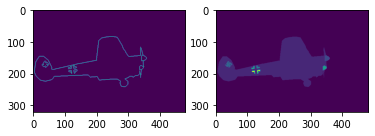

M: 5


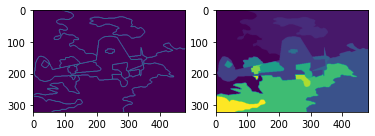

M: 6


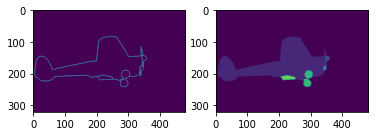

In [ ]:
# example of visualization
read_image_truth("3063","test")

# **Kmeans implementation**
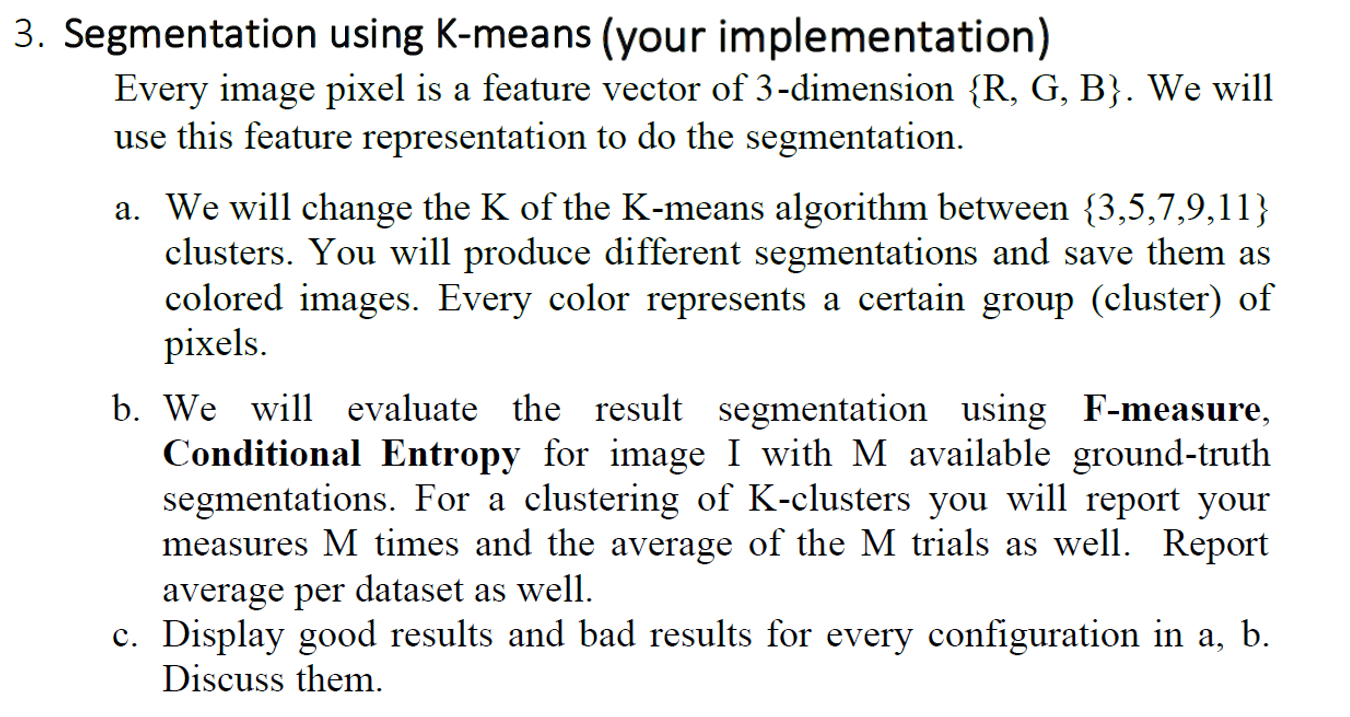

In [ ]:
def K_means(X,k):
  # to avoid floating point error
  epslion = 0.0005
  # keep track of | new centroids - old centroids |
  diff = 1
  # max number of iterations
  max_it = 300
  # current iteration
  it = 0
  # initalize random centroids
  centroids = X.sample(n=k,replace=False).values
  pixels = X.to_numpy()
  # labels array
  labels=np.zeros(X.shape[0])
  while diff > epslion and it < max_it:
    # compute distances between data and centroids
    dist = pairwise_distances(pixels,centroids)
    # assign labels 
    labels = np.argmin(dist,axis = 1)
    # get new centroids
    new_centroids = pd.DataFrame(X).groupby(by=labels).mean().values
    old_lbl = set(np.arange(k))
    new_lbl = set(labels)
    empty_cluster = old_lbl - new_lbl
    if len(empty_cluster) > 0 :
      print("labels",new_lbl,"old",old_lbl, "empty:",empty_cluster)
      rand_points = X.sample(n=len(empty_cluster),replace=False).values
      empty_cluster = sorted(empty_cluster)
      for i,idx in enumerate(empty_cluster):
         new_centroids=np.insert(new_centroids, idx, rand_points[i], 0) 
    if new_centroids.shape[0] != k:
      print("labels",new_lbl,"old",old_lbl, "empty:",empty_cluster)
    diff= abs((new_centroids - centroids).sum())
    centroids = new_centroids
    it +=1
  return labels

# **Evaluation**

In [ ]:
def compute_f1_score(predicted, true_labels):
  # get contingency table
  con = contingency_matrix(predicted,true_labels)
  f = 0
  # get index of max in each col
  idx = np.argmax(con,axis=1)
  for i in range(con.shape[0]):
    # max in row
    n = con.max(axis=1)[i]
    # compute percision , recall , f score for each class
    prec = n/sum(con[i])
    recall = n /sum(con[:,idx[i]])
    f1 =(2*prec*recall)/(prec+recall)
    # avoid divide by zero
    f1 = 0 if np.isnan(f1) else f1
    f+= f1
  return f/con.shape[0]


In [ ]:
def compute_conditional_entropy(predicted, true_labels):
  # get contingency table
  con = contingency_matrix(predicted,true_labels)
  # total number of samples
  n = sum(sum(con))
  conditional_entropy = 0
  for i in range(con.shape[0]):
    entropy = 0
    # get sum of row
    row_sum = sum(con[i])
    for elm in con[i]:
      entropy -= 0 if elm==0 else (elm/row_sum)*log10(elm/row_sum)
    conditional_entropy += (row_sum/n)*entropy
  return conditional_entropy

# **Tune k parameter on training set**

In [ ]:
# k dictionary to keep track of the best k
k_dic = {3:0,5:0,7:0,9:0,11:0}
path ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/train"
results_path = "/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/results.docx"
img_count = 1
doc = docx.Document(results_path)
for image in os.listdir(path):
  print("process image:",image,"number : ",img_count)
  img_count+=1
  # create folder for image result
  img_path = f"/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/tunning/{image.split('.')[0]}"
  os.makedirs(img_path)
  # visualize images
  read_image_truth(image.split('.')[0],"train",doc)
  doc.save(results_path)
  im = Image.open(os.path.join(path, image))
  # get pixels of image
  im = im.convert('RGB')
  pixels = np.array(im.getdata())
  # convert image to dataframe
  img_df = pd.DataFrame(pixels)
  img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)
  img_df.head()

  conditional_entropy = {3:0,5:0,7:0,9:0,11:0}
  fscore = {3:0,5:0,7:0,9:0,11:0}
  for k in k_dic.keys():
    print(" k = ",k)
    labels = K_means(img_df,k)
    # show segmentation result
    segmented_image = labels
    segmented_image = segmented_image.reshape((np.array(im).shape[0],np.array(im).shape[1]))
    #plotting the image
    pyplot.imshow(segmented_image)
    imgplot = pyplot.savefig(img_path+f"/k_{k}.png")
    doc.add_paragraph(f"************* segmentation result {k}**************")
    doc.add_picture(img_path+f"/k_{k}.png")
    pyplot.show()
    doc.save(results_path)

    # evaluate clustring with m ground truth
    ground_segs = get_seg(image.split('.')[0],"train")
    total_f = 0
    total_con = 0
    for i in range(ground_segs.shape[0]):
      f_score = compute_f1_score(labels,ground_segs[i])
      total_f +=f_score
      con_ent = compute_conditional_entropy(labels,ground_segs[i])
      total_con+=con_ent
      doc.add_paragraph(f'M{str(i)}  fscore: {str(f_score)}  conditional_entropy: {str(con_ent)}')
    avg_f = total_f / ground_segs.shape[0]
    avg_ent = total_con/ ground_segs.shape[0]
    conditional_entropy[k] = avg_ent
    fscore[k]=avg_f
    doc.add_paragraph(f'>> Average  fscore: {str(avg_f)}  conditional_entropy: {str(avg_ent)}')
    doc.add_paragraph("************************************")
    doc.save(results_path)
  # increase best k based on fscore
  k_dic[max(fscore,key=fscore.get)] +=1
  # save checkpoint of dictionary
  doc.add_paragraph(str(k_dic))
  doc.add_paragraph("************************************")




# **Testing**

In [ ]:
path ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test"
results_path = "/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test_results.docx"
img_count = 1
doc = docx.Document(results_path)
for image in os.listdir(path):
  if img_count > 50:
    break
  print("process image:",image,"number : ",img_count)
  img_count+=1
  # visualize images
  read_image_truth(image.split('.')[0],"test")
  doc.save(results_path)
  im = Image.open(os.path.join(path, image))
  # get pixels of image
  im = im.convert('RGB')
  pixels = np.array(im.getdata())
  # convert image to dataframe
  img_df = pd.DataFrame(pixels)
  img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)
  # show segmentation result
  segmented_image = labels
  segmented_image = segmented_image.reshape((np.array(im).shape[0],np.array(im).shape[1]))
  #plotting the image
  pyplot.imshow(segmented_image)
  imgplot = pyplot.savefig("k_3.png")
  doc.add_paragraph("************* segmentation result 3**************")
  doc.add_picture("k_3.png")
  pyplot.show()
  doc.save(results_path)

  # evaluate clustring with m ground truth
  ground_segs = get_seg(image.split('.')[0],"test")
  total_f = 0
  total_con = 0
  for i in range(ground_segs.shape[0]):
    f_score = compute_f1_score(labels,ground_segs[i])
    total_f +=f_score
    con_ent = compute_conditional_entropy(labels,ground_segs[i])
    total_con+=con_ent
    doc.add_paragraph(f'M{str(i)}  fscore: {str(f_score)}  conditional_entropy: {str(con_ent)}')
    avg_f = total_f / ground_segs.shape[0]
    avg_ent = total_con/ ground_segs.shape[0]
    doc.add_paragraph(f'>> Average  fscore: {str(avg_f)}  conditional_entropy: {str(avg_ent)}')
    doc.add_paragraph("************************************")
    doc.save(results_path)
  doc.add_paragraph("************************************")


# **Big Picture**
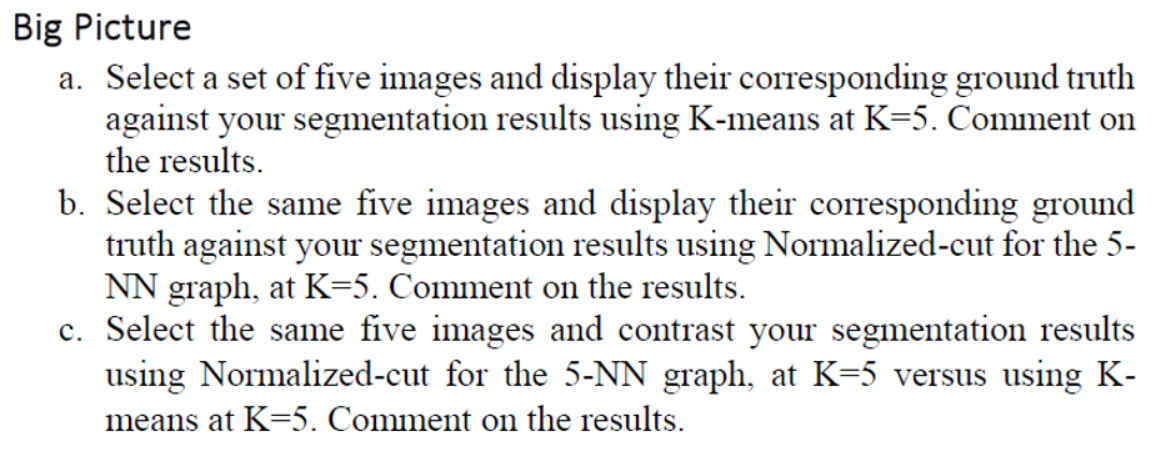

**Selecting** and plotting the originaly groundTruth of the selected five images

Original Image
Ground truth images 
M =  6
M: 1


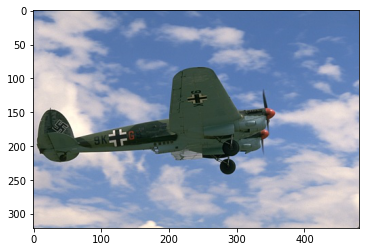

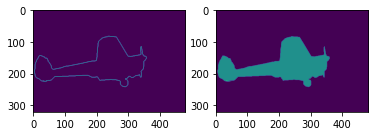

M: 2


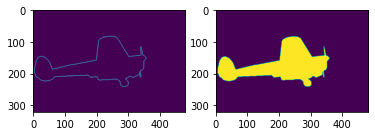

M: 3


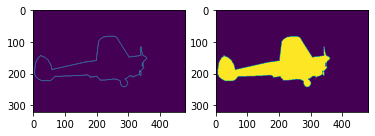

M: 4


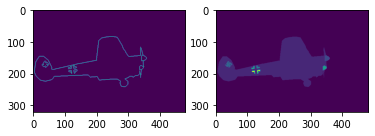

M: 5


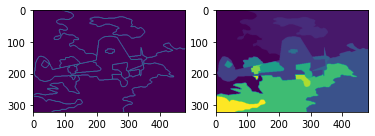

M: 6


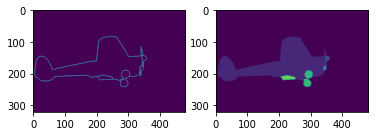

Original Image
Ground truth images 
M =  5
M: 1


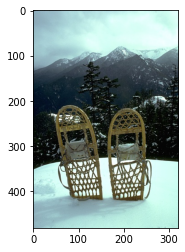

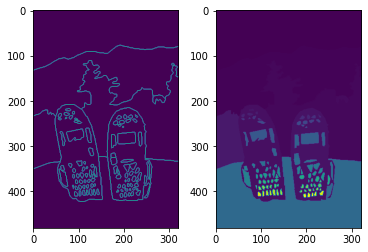

M: 2


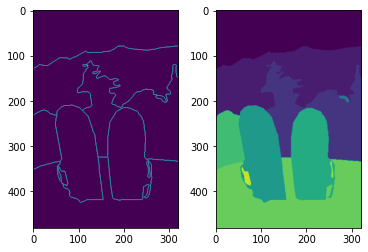

M: 3


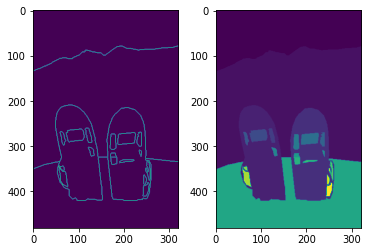

M: 4


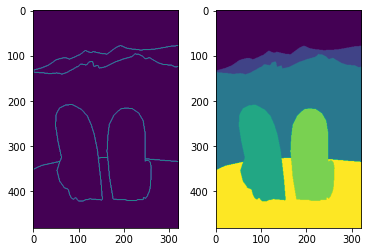

M: 5


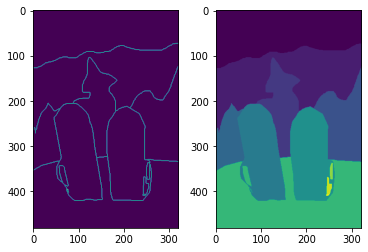

Original Image
Ground truth images 
M =  5
M: 1


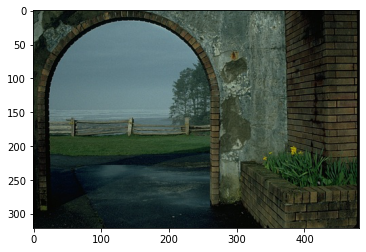

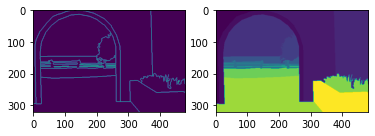

M: 2


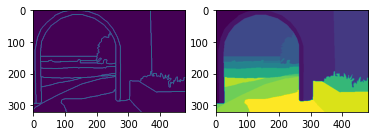

M: 3


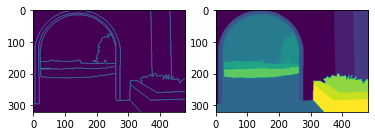

M: 4


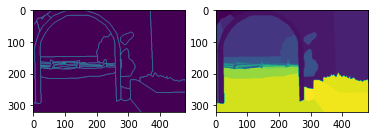

M: 5


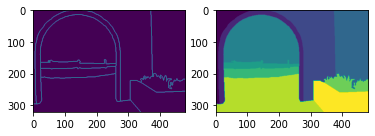

Original Image
Ground truth images 
M =  5
M: 1


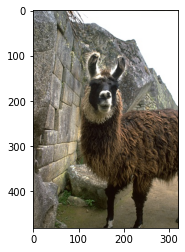

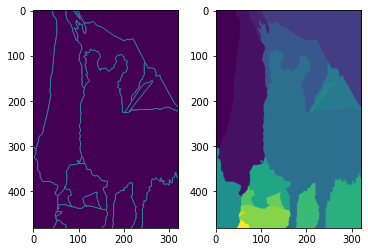

M: 2


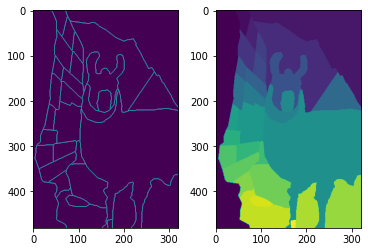

M: 3


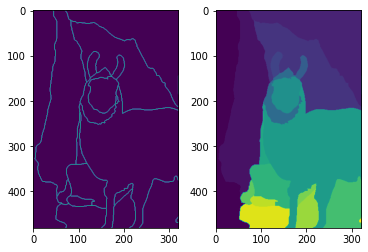

M: 4


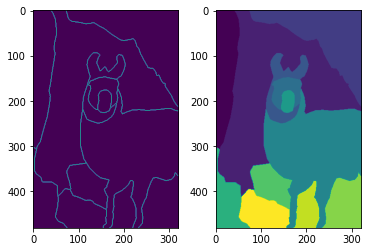

M: 5


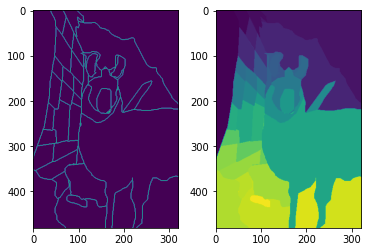

Original Image
Ground truth images 
M =  5
M: 1


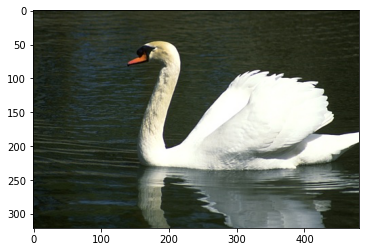

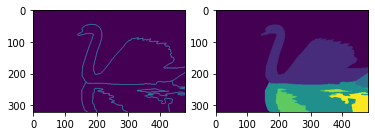

M: 2


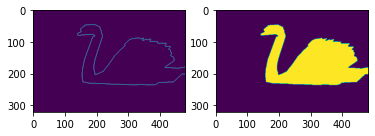

M: 3


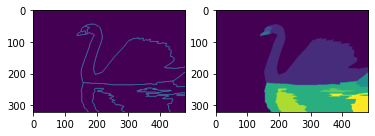

M: 4


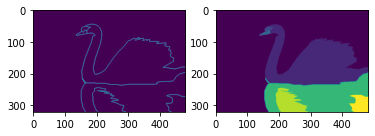

M: 5


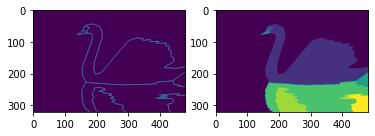

In [ ]:
# Showing the selected five images' groundTruth
read_image_truth("3063","test")
read_image_truth("2018","test")
read_image_truth("5096","test")
read_image_truth("6046","test")
read_image_truth("8068","test")

# a)

In [ ]:
def run_kmeans(path,name):
  im = Image.open(path)

  im = im.convert('RGB') # get pixels of image
  pixels = np.array(im.getdata())

  # converting image to dataframe
  img_df = pd.DataFrame(pixels)
  img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)

  # for k = 5
  k = 5
  labels = K_means(img_df, k) # we converted the image to a dataframe then we passed it to the k-means function with the associated k

  # show segmentation result
  segmented_image = labels 
  segmented_image = segmented_image.reshape((np.array(im).shape[0],np.array(im).shape[1])) # to be able to display the image as a matrix

  # plotting the image
  pyplot.imshow(segmented_image)
  pyplot.show()


  # the measures 
  ground_segs = get_seg(name,"test")
  total_f = 0
  total_con = 0
  for i in range(ground_segs.shape[0]):
    f_score = compute_f1_score(labels, ground_segs[i])
    total_f += f_score
    con_ent = compute_conditional_entropy(labels,ground_segs[i])
    total_con += con_ent
  avg_f = total_f / ground_segs.shape[0]
  avg_ent = total_con/ ground_segs.shape[0]

  print("Average F-measure : ", avg_f)
  print("Average entropy : ", avg_ent)

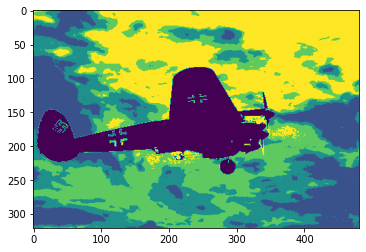

Average F-measure :  0.5280139532293684
Average entropy :  0.11225977295102128


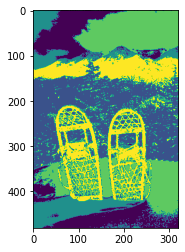

Average F-measure :  0.4430000287948072
Average entropy :  0.546854918377249


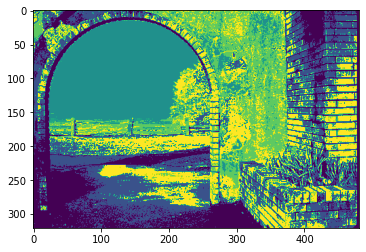

Average F-measure :  0.4999559861917925
Average entropy :  0.7210260105041936


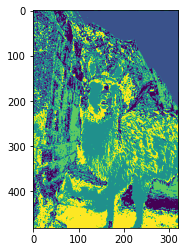

Average F-measure :  0.5143757188104001
Average entropy :  0.7765816442616964


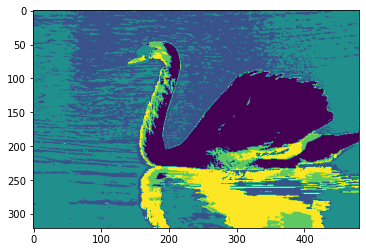

Average F-measure :  0.5860721264508238
Average entropy :  0.18679724156168204


In [ ]:

path1 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/3063.jpg"
run_kmeans(path1,"3063")

path2 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/2018.jpg"
run_kmeans(path2,"2018")

path3 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/5096.jpg"
run_kmeans(path3,"5096")

path4 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/6046.jpg"
run_kmeans(path4,"6046")

path5 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/8068.jpg"
run_kmeans(path5,"8068")

# b)

In [ ]:
def knn(path,name):
  im = Image.open(path)

  im = im.convert('RGB') # get pixels of image
  pixels = np.array(im.getdata())

  # converting image to dataframe
  img_df = pd.DataFrame(pixels)
  img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)

  # clustering using KNN
  clustering = SpectralClustering(affinity = 'nearest_neighbors', n_neighbors = 5, n_clusters = 5, assign_labels = 'discretize', random_state = 0).fit(np.array(img_df))

  # for kNN where k = 5
  labels = clustering.labels_

  # show segmentation result
  segmented_image = labels 
  segmented_image = segmented_image.reshape((np.array(im).shape[0],np.array(im).shape[1])) # to be able to display the image as a matrix

  # plotting the image
  pyplot.imshow(segmented_image)
  pyplot.show()

  # the measures 
  ground_segs = get_seg(name,"test")
  total_f = 0
  total_con = 0
  for i in range(ground_segs.shape[0]):
    f_score = compute_f1_score(labels, ground_segs[i])
    total_f += f_score
    con_ent = compute_conditional_entropy(labels,ground_segs[i])
    total_con += con_ent
  avg_f = total_f / ground_segs.shape[0]
  avg_ent = total_con/ ground_segs.shape[0]

  print("Average F-measure : ", avg_f)
  print("Average entropy : ", avg_ent)

Picture 1

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


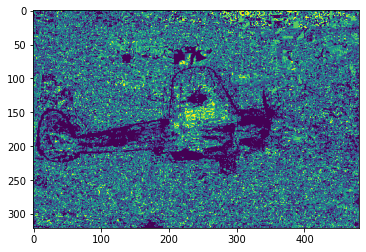

Average F-measure :  0.2968065822313833
Average entropy :  0.2971368953481392


In [ ]:
path1 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/3063.jpg"
knn(path1,"3063")

Picture 2

In [ ]:
path2 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/2018.jpg"
knn(path2,"2018")

picture 3

In [ ]:
path3 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/5096.jpg"
knn(path3,"5096")

Picture 4

In [ ]:
path4 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/6046.jpg"
knn(path4,"6046")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Picture 5

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


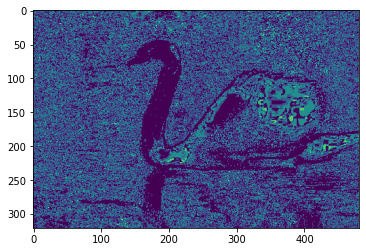

Average F-measure :  0.26428553749368944
Average entropy :  0.4348731322841834


In [ ]:
path5 ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test/8068.jpg"
knn(path5,"8068")

# **Extra**
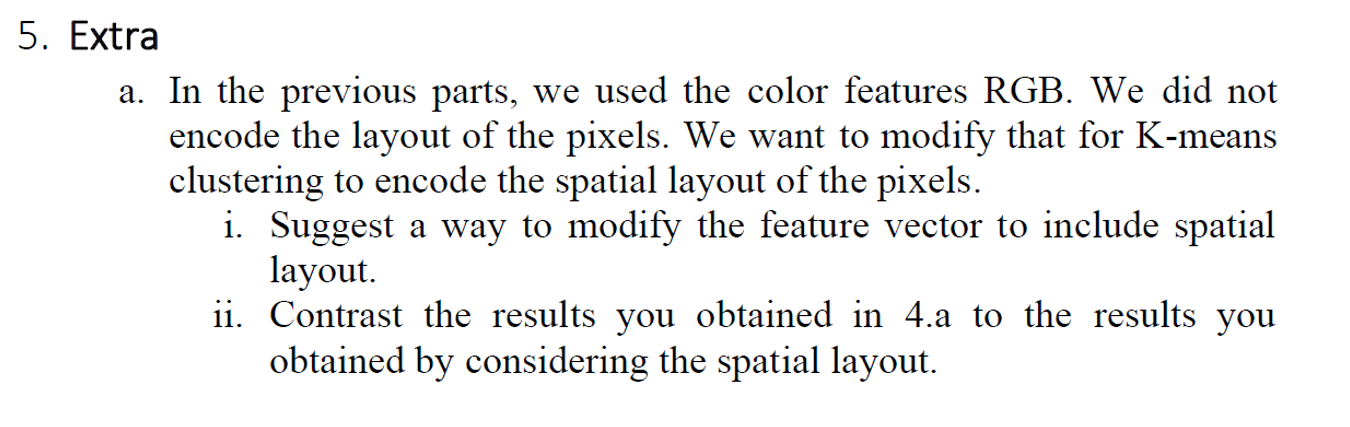

In [ ]:
# new feature
# k dictionary to keep track of the best k
k_dic = {3:0,5:0,7:0,9:0,11:0}
path ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/train"
results_path = "/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/results_bonus.docx"
img_count = 1
doc = docx.Document(results_path)
for image in os.listdir(path):
  print("process image:",image,"number : ",img_count)
  img_count+=1
  img_path = f"/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/tunning_bonus/{image.split('.')[0]}"
  os.makedirs(img_path)
  # visualize images
  read_image_truth(image.split('.')[0],"train")
  doc.save(results_path)
  im = Image.open(os.path.join(path, image))
  # get pixels of image
  im = im.convert('RGB')
  pixels = np.array(im.getdata())
  # convert image to dataframe
  img_df = pd.DataFrame(pixels)
  img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)

  width = np.array(im).shape[0]
  height = np.array(im).shape[1]
  pix_no = width * height
  layout_feat = np.empty((0,2))
  
  for i in range(height):
    for j in range(width):
      layout_feat = np.vstack((layout_feat,np.array([j,i])))
  img_df['x'] = layout_feat[:,0]
  img_df['y'] = layout_feat[:,1]
 
  conditional_entropy = {3:0,5:0,7:0,9:0,11:0}
  fscore = {3:0,5:0,7:0,9:0,11:0}
  for k in k_dic.keys():
    print(" k = ",k)
    labels = K_means(img_df,k)
    # show segmentation result
    segmented_image = labels
    segmented_image = segmented_image.reshape((np.array(im).shape[0],np.array(im).shape[1]))
    #plotting the image
    pyplot.imshow(segmented_image)
    imgplot = pyplot.savefig("result.png")
    doc.add_paragraph(f"***** segmentation result {k}******")
    doc.add_picture("/content/result.png")
    pyplot.show()
    doc.save(results_path)

    # evaluate clustring with m ground truth
    ground_segs = get_seg(image.split('.')[0],"train")
    total_f = 0
    total_con = 0
    for i in range(ground_segs.shape[0]):
      f_score = compute_f1_score(labels,ground_segs[i])
      total_f +=f_score
      con_ent = compute_conditional_entropy(labels,ground_segs[i])
      total_con+=con_ent
      doc.add_paragraph(f'M{str(i)}  fscore: {str(f_score)}  conditional_entropy: {str(con_ent)}')
      print(f'M{str(i)}  fscore: {str(f_score)}  conditional_entropy: {str(con_ent)}')
    avg_f = total_f / ground_segs.shape[0]
    avg_ent = con_ent / ground_segs.shape[0]
    conditional_entropy[k] = avg_ent
    fscore[k]=avg_f
    doc.add_paragraph(f'>> Average  fscore: {str(avg_f)}  conditional_entropy: {str(avg_ent)}')
    print(f'>> Average  fscore: {str(avg_f)}  conditional_entropy: {str(avg_ent)}')
    doc.add_paragraph("************")
    doc.save(results_path)
  # increase best k based on fscore
  print("best k = ",max(fscore,key=fscore.get))
  k_dic[max(fscore,key=fscore.get)] +=1
  # save checkpoint of dictionary
  doc.add_paragraph(str(k_dic))
  doc.add_paragraph("************")
  print("****************")



# **Testing**

In [ ]:
path ="/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test"
results_path = "/content/drive/MyDrive/Colab Notebooks/pattern/lab2/data/test_results.docx"
img_count = 1
doc = docx.Document(results_path)
for image in os.listdir(path):
  if img_count > 50:
    break
  print("process image:",image,"number : ",img_count)
  img_count+=1
  # visualize images
  read_image_truth(image.split('.')[0],"test")
  doc.save(results_path)
  im = Image.open(os.path.join(path, image))
  # get pixels of image
  im = im.convert('RGB')
  pixels = np.array(im.getdata())
  # convert image to dataframe
  img_df = pd.DataFrame(pixels)
  img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)
  width = np.array(im).shape[0]
  height = np.array(im).shape[1]
  pix_no = width * height
  layout_feat = np.empty((0,2))
  
  for i in range(height):
    for j in range(width):
      layout_feat = np.vstack((layout_feat,np.array([j,i])))
  img_df['x'] = layout_feat[:,0]
  img_df['y'] = layout_feat[:,1]
  labels = K_means(img_df,3)
  # show segmentation result
  segmented_image = labels
  segmented_image = segmented_image.reshape((np.array(im).shape[0],np.array(im).shape[1]))
  #plotting the image
  pyplot.imshow(segmented_image)
  imgplot = pyplot.savefig("k_3.png")
  doc.add_paragraph("************* segmentation result 3**************")
  doc.add_picture("k_3.png")
  pyplot.show()
  doc.save(results_path)

  # evaluate clustring with m ground truth
  ground_segs = get_seg(image.split('.')[0],"test")
  total_f = 0
  total_con = 0
  for i in range(ground_segs.shape[0]):
    f_score = compute_f1_score(labels,ground_segs[i])
    total_f +=f_score
    con_ent = compute_conditional_entropy(labels,ground_segs[i])
    total_con+=con_ent
    doc.add_paragraph(f'M{str(i)}  fscore: {str(f_score)}  conditional_entropy: {str(con_ent)}')
    avg_f = total_f / ground_segs.shape[0]
    avg_ent = total_con/ ground_segs.shape[0]
    doc.add_paragraph(f'>> Average  fscore: {str(avg_f)}  conditional_entropy: {str(avg_ent)}')
    doc.add_paragraph("************************************")
    doc.save(results_path)
  doc.add_paragraph("************************************")
